In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os
from hep_ml import reweight
import pickle

In [2]:
!pip install hep_ml

Defaulting to user installation because normal site-packages is not writeable


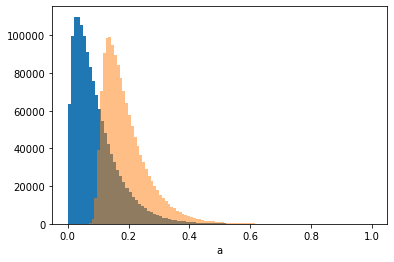

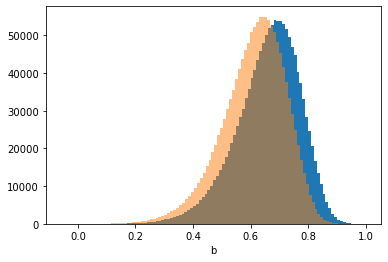

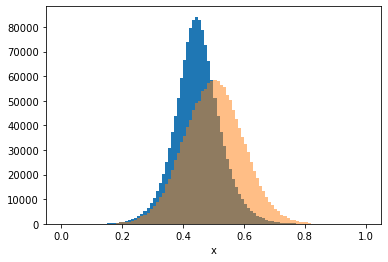

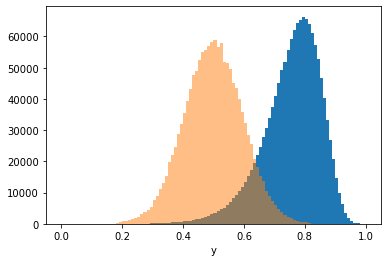

In [3]:
# target = data
# nothing = mc

nevs = 2000000
dof = 3
pdf1 = chi2(dof)
sample1 = pdf1.rvs(nevs)
sample1 = MinMaxScaler((0, 1)).fit_transform(sample1.reshape(-1, 1)).reshape(-1)
sample1_target = sample1 + 0.1 + 0.01 * np.random.normal(size=sample1.shape)
sample1_train, sample1_test = train_test_split(sample1, test_size=0.3)
sample1_target_train, sample1_target_test = train_test_split(sample1_target, test_size=0.3)
plt.hist(sample1_train, bins=100)
plt.hist(sample1_target_train, bins=100, alpha=0.5)
plt.xlabel('a')
plt.show()

pdf2 = weibull_min(10, 1)
sample2 = pdf2.rvs(nevs)
sample2 = MinMaxScaler((0, 1)).fit_transform(sample2.reshape(-1, 1)).reshape(-1)
sample2_target = sample2 - 0.05 + 0.01 * np.random.normal(size=sample2.shape)
sample2_train, sample2_test = train_test_split(sample2, test_size=0.3)
sample2_target_train, sample2_target_test = train_test_split(sample2_target, test_size=0.3)
plt.hist(sample2_train, bins=100)
plt.hist(sample2_target_train, bins=100, alpha=0.5)
plt.xlabel('b')
plt.show()

sample3 = np.log1p(sample1) + np.log1p(sample2)
sample3 = MinMaxScaler((0, 1)).fit_transform(sample3.reshape(-1, 1)).reshape(-1)
sample3_target = np.log1p(sample1_target) + np.log1p(sample2_target)
sample3_target = QuantileTransformer(output_distribution='normal').fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
sample3_target = MinMaxScaler((0, 1)).fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
sample3_train, sample3_test = train_test_split(sample3, test_size=0.3)
sample3_target_train, sample3_target_test = train_test_split(sample3_target, test_size=0.3)
plt.hist(sample3_train, bins=100)
plt.hist(sample3_target_train, bins=100, alpha=0.5)
plt.xlabel('x')
plt.show()

sample4 = np.log1p(sample1) + np.log1p(sample2) - np.log1p(sample1 * sample2) + 0.05
sample4 = MinMaxScaler((0, 1)).fit_transform(sample4.reshape(-1, 1)).reshape(-1)
sample4_target = np.log1p(sample1_target) + np.log1p(sample2_target) - np.log1p(sample1_target * sample2_target) + 0.05
sample4_target = QuantileTransformer(output_distribution='normal').fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
sample4_target = MinMaxScaler((0, 1)).fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
sample4_train, sample4_test = train_test_split(sample4, test_size=0.3)
sample4_target_train, sample4_target_test = train_test_split(sample4_target, test_size=0.3)
plt.hist(sample4_train, bins=100)
plt.hist(sample4_target_train, bins=100, alpha=0.5)
plt.xlabel('y')
plt.show()

df = pd.DataFrame({'a': sample1_train, 'b': sample2_train, 'x': sample3_train, 'y': sample4_train})
df_target = pd.DataFrame({'a': sample1_target_train, 'b': sample2_target_train, 'x': sample3_target_train, 'y': sample4_target_train})

df_test = pd.DataFrame({'a': sample1_test, 'b': sample2_test, 'x': sample3_test, 'y': sample4_test})
df_target_test = pd.DataFrame({'a': sample1_target_test, 'b': sample2_target_test, 'x': sample3_target_test, 'y': sample4_target_test})

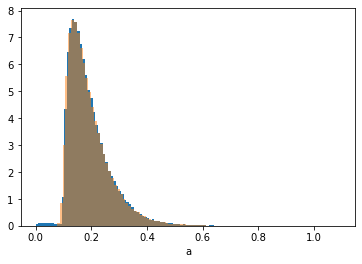

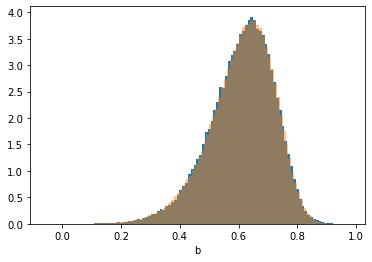

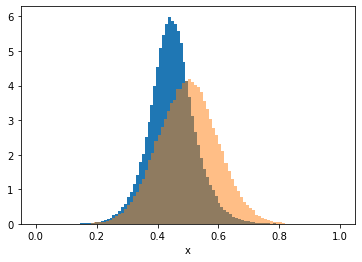

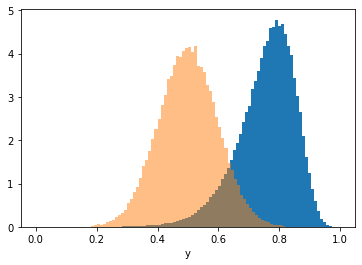

In [5]:
context_vars = ['a', 'b']
target_vars = ['x', 'y']

reweighter = reweight.GBReweighter(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=1000,
    gb_args={"subsample": 0.4},
)
bins_reweighter = reweight.BinsReweighter(n_bins=200, n_neighs=1.)

bins_reweighter.fit(
    df[context_vars].values,
    df_target[context_vars].values,
)

train_weights = bins_reweighter.predict_weights(
    df[context_vars].values,
)

test_weights = bins_reweighter.predict_weights(
    df_test[context_vars].values,
)

# add weights to mc dataframe and ones to data dataframe
df["weight"] = train_weights
df_target["weight"] = np.ones(len(df_target))
df_test["weight"] = test_weights
df_target_test["weight"] = np.ones(len(df_target_test))

# plot
for var in context_vars + target_vars:
    plt.hist(df_test[var], bins=100, density=True, weights=df_test['weight'])
    plt.hist(df_target_test[var], bins=100, alpha=0.5, density=True)
    plt.xlabel(var)
    plt.show()

In [7]:
output_dir = "./samples"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
pickle.dump(bins_reweighter, open('./samples/reweighter.pkl', "wb"))

# save as parquet the four samples  
df.to_parquet(os.path.join(output_dir, "train.parquet"))    
df_target.to_parquet(os.path.join(output_dir, "train_target.parquet"))
df_test.to_parquet(os.path.join(output_dir, "test.parquet"))
df_target_test.to_parquet(os.path.join(output_dir, "test_target.parquet"))